In [226]:
%pylab inline
from train import train_simple
from models import *
from datasets import UnlabelledDataSet

Populating the interactive namespace from numpy and matplotlib


/Users/wellecks/own_files/env/minpy_dev/lib/python2.7/site-packages/IPython/core/magics/pylab.py:161: UserWarning: pylab import has clobbered these variables: ['rc', 'colors']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


### Visualize Approximate Posterior for Simple Dataset

4 point, 4 class dataset

In [227]:
data = np.array([[-1.,-1.], [-1., 1.], [1., -1.], [1., 1.]])

In [228]:
def run_simple(enc, data, flow=None, **kwargs):
    tf.reset_default_graph()

    dim_x, dim_z, enc_dims, dec_dims = data.shape[1], 2, [100, 100], [100, 100]
    encoder_net = lambda x: nn(x, enc_dims, name='encoder', act=tf.nn.tanh)
    decoder_net = lambda z: nn(z, dec_dims, name='decoder', act=tf.nn.tanh)

    if flow is None:
        encoder = enc(encoder_net, dim_z)
    else:
        encoder = enc(encoder_net, dim_z, flow=flow)
    decoder = basic_decoder(decoder_net, dim_x, act=None)

    extra_settings = {
        'flow length': flow,
        'encoder structure': enc_dims,
        'decoder structure': dec_dims,
        'anneal_lr': False
    }

    ops, sess = train_simple(
                    dim_x=dim_x, 
                    dim_z=dim_z, 
                    encoder=encoder, 
                    decoder=decoder, 
                    training_dataset=UnlabelledDataSet(data), 
                    rec_err_type='l2_loss',
                    **kwargs
    )
    return ops, sess

def plot_results(ops, data):
    # Posterior samples
    samples = 500
    dim_z = 2

    x_ = np.repeat(data, samples, axis=0)
    y_ = np.repeat(np.arange(data.shape[0]), samples)
    e_ = np.random.normal(size=(x_.shape[0], dim_z))
    zs = sess.run(ops['z'], feed_dict={ops['x']: x_, ops['e']: e_})
    
    # Reconstructions
    e_ = np.random.normal(size=(data.shape[0], dim_z))
    x_rec = sess.run(ops['out'], feed_dict={ops['x']: data, ops['e']: e_})

    # Plot samples on left and reconstructions on right
    fig, axs = plt.subplots(1, 2, figsize=(14, 6))
    axs[0].scatter(zs[:, 0], zs[:, 1], c=y_)
    axs[0].set_title('Posterior samples for each datapoint')
    
    axs[1].scatter(x_rec[:, 0], x_rec[:, 1], c=np.arange(data.shape[0]));
    axs[1].set_title('Reconstructed data')
    plt.show()

#### Vanilla VAE

In [ ]:
ops, sess = run_simple(basic_encoder, data, max_epochs=10000, print_every=2500)

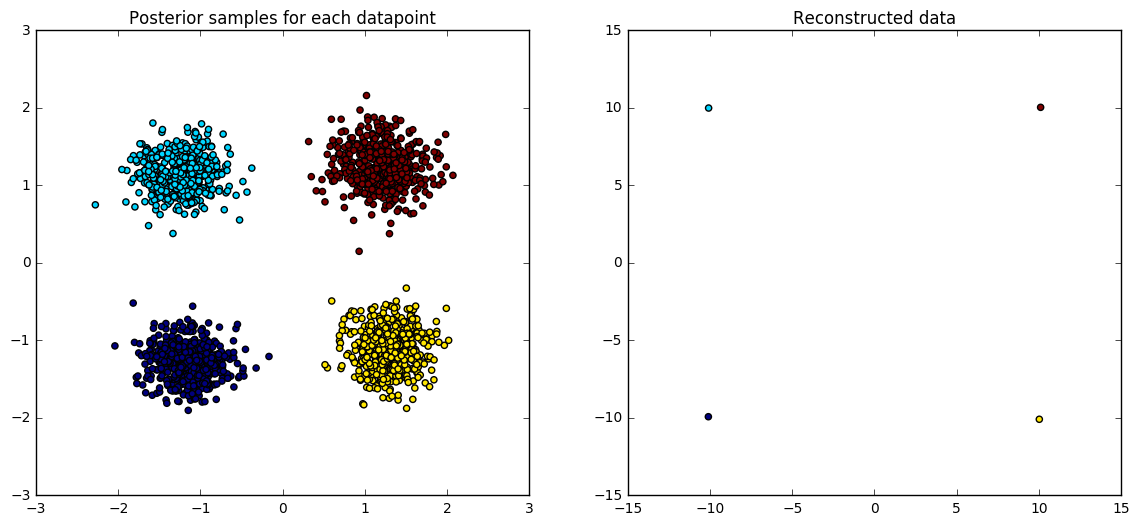

In [28]:
plot_results(ops, data)

#### IAF 1 step

In [31]:
ops, sess = run_simple(iaf_encoder, data, flow=1, max_epochs=10000, print_every=2500)

Epoch: 0	 Training loss: 395.39, Validation loss 0.00 (0.1)
Epoch: 2500	 Training loss: 5.00, Validation loss 0.00 (0.0)
Epoch: 5000	 Training loss: 3.81, Validation loss 0.00 (0.0)
Epoch: 7500	 Training loss: 2.76, Validation loss 0.00 (0.0)


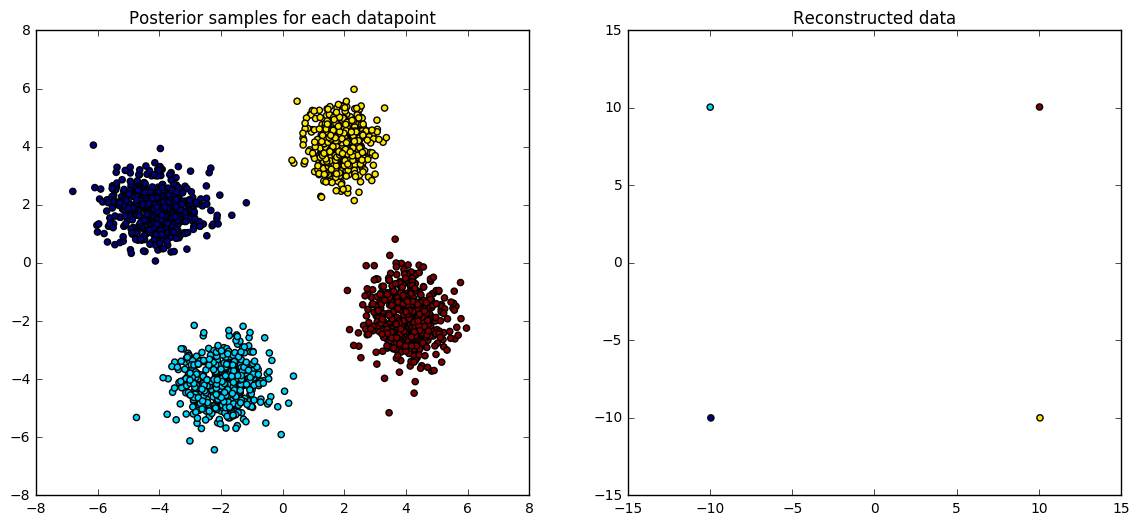

In [32]:
plot_results(ops, data)

#### NF 10 steps

In [52]:
ops, sess = run_simple(nf_encoder, data, flow=10)

Epoch: 0	 Training loss: 410.26, Validation loss 0.00 (0.2)
Epoch: 1000	 Training loss: 7.27, Validation loss 0.00 (0.0)
Epoch: 2000	 Training loss: 6.52, Validation loss 0.00 (0.0)
Epoch: 3000	 Training loss: 6.21, Validation loss 0.00 (0.0)
Epoch: 4000	 Training loss: 6.23, Validation loss 0.00 (0.0)
Epoch: 5000	 Training loss: 11.07, Validation loss 0.00 (0.0)
Epoch: 6000	 Training loss: 6.97, Validation loss 0.00 (0.0)
Epoch: 7000	 Training loss: 308.45, Validation loss 0.00 (0.0)
Epoch: 8000	 Training loss: 4.23, Validation loss 0.00 (0.0)
Epoch: 9000	 Training loss: 5.54, Validation loss 0.00 (0.0)


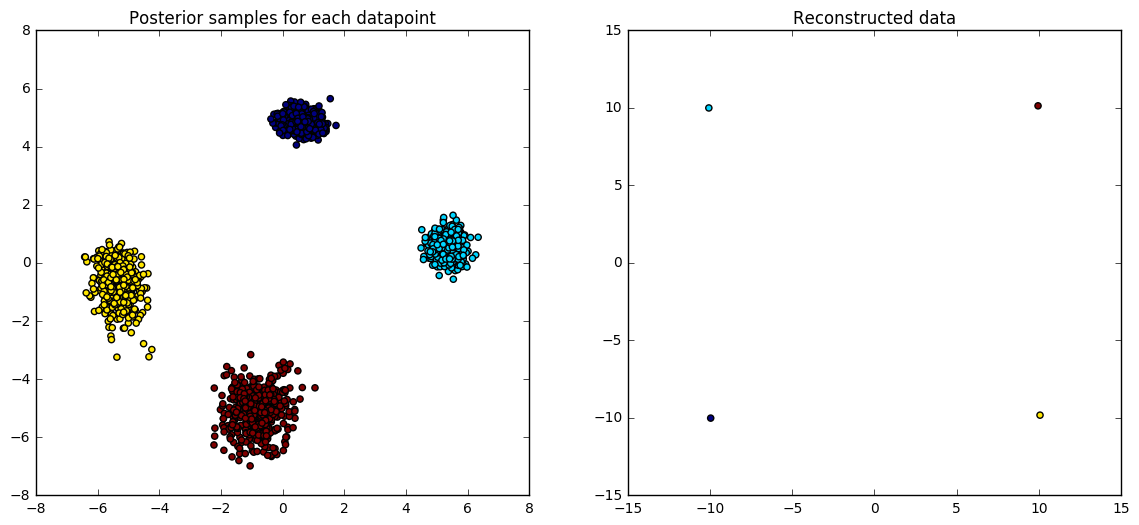

In [55]:
plot_results(ops, data)

### Mixture Model

In [17]:
def plot_results(ops, data, labels):
    samples = 500
    dim_z = 2
    
    fig, axs = plt.subplots(1, 3, figsize=(15, 4.5))
    
    # Posterior Samples
    # Take a data point from each class
    x_ = np.repeat(data[[(ys==i).argmax() for i in range(3)]], samples, axis=0)
    y_ = np.repeat(np.arange(3), samples)
    e_ = np.random.normal(size=(x_.shape[0], dim_z))
    zs = sess.run(ops['z'], feed_dict={ops['x']: x_, ops['e']: e_})
    axs[0].scatter(zs[:, 0], zs[:, 1], c=y_)
    axs[0].set_title("Posterior samples for 3 data points")
    
    # Latent z values for each data point
    x_ = data
    e_ = np.random.normal(size=(x_.shape[0], dim_z))
    zs = sess.run(ops['z'], feed_dict={ops['x']: x_, ops['e']: e_})
    axs[1].scatter(zs[:, 0], zs[:, 1], c=labels)
    axs[1].set_title('latent z values for each data point')
    
    # Reconstructions
    e_ = np.random.normal(size=(data.shape[0], dim_z))
    x_rec = sess.run(ops['out'], feed_dict={ops['x']: data, ops['e']: e_})
    axs[2].scatter(x_rec[:, 0], x_rec[:, 1], c=labels);
    axs[2].set_title('Reconstructed data')
    
    plt.show()

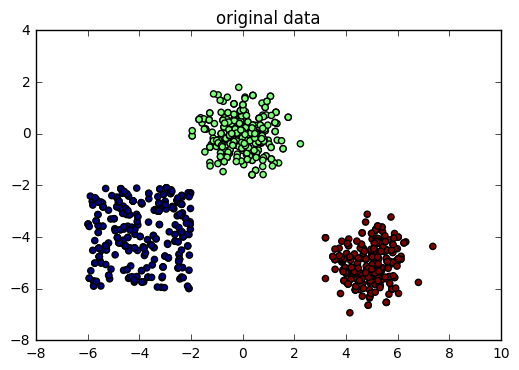

In [7]:
N = 1000
xs = np.vstack((
    np.random.uniform(-6, -2, size=(N/3, 2)),
    np.random.multivariate_normal([0, 0], np.eye(2)/2, size=N/3),
    np.random.multivariate_normal([5, -5], np.eye(2)/2, size=N/3)
))
ys = np.repeat(np.arange(3), N/3)


idxs = np.random.choice(range(xs.shape[0]), xs.shape[0])
xs, ys = xs[idxs], ys[idxs]

plt.scatter(xs[:, 0], xs[:, 1], c=ys)
plt.title('original data');

#### Vanilla VAE

In [20]:
ops, sess = run_simple(basic_encoder, xs, max_epochs=500, print_every=100)

Epoch: 0	 Training loss: 1160.57, Validation loss 0.00 (0.1)
Epoch: 100	 Training loss: 8.69, Validation loss 0.00 (0.0)
Epoch: 200	 Training loss: 8.06, Validation loss 0.00 (0.0)
Epoch: 300	 Training loss: 8.29, Validation loss 0.00 (0.0)
Epoch: 400	 Training loss: 7.77, Validation loss 0.00 (0.0)


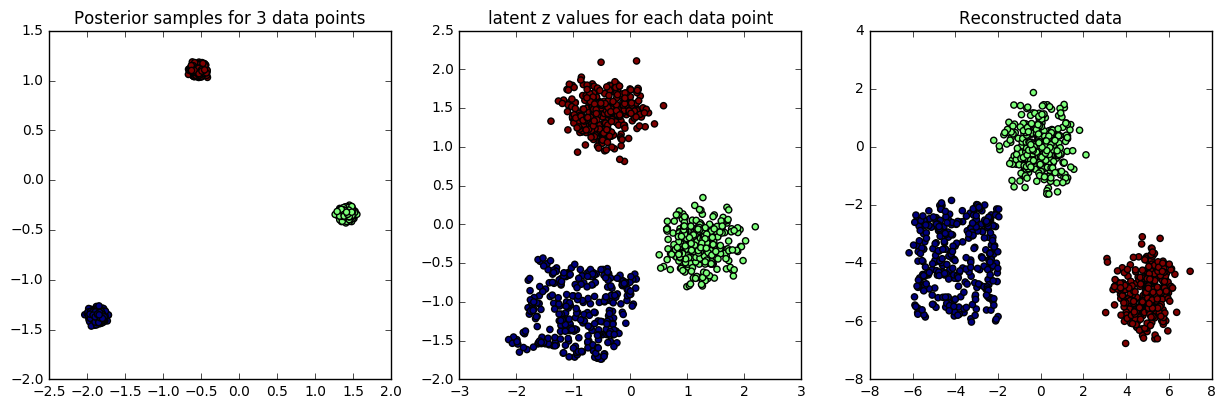

In [21]:
plot_results(ops, xs, ys)

#### IAF Flow 1

In [8]:
ops, sess = run_simple(iaf_encoder, xs, flow=1, max_epochs=500, print_every=100)

Epoch: 0	 Training loss: 1047.84, Validation loss 0.00 (0.1)
Epoch: 100	 Training loss: 9.45, Validation loss 0.00 (0.1)
Epoch: 200	 Training loss: 8.46, Validation loss 0.00 (0.0)
Epoch: 300	 Training loss: 8.36, Validation loss 0.00 (0.1)
Epoch: 400	 Training loss: 8.16, Validation loss 0.00 (0.1)


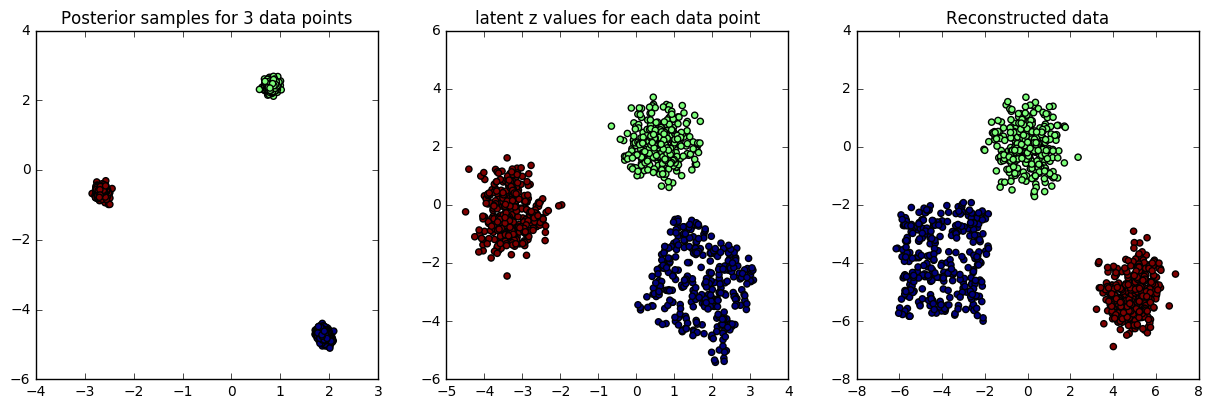

In [18]:
plot_results(ops, xs, ys)

#### NF Flow 10

In [24]:
ops, sess = run_simple(nf_encoder, xs, flow=10, max_epochs=2000, print_every=100)

Epoch: 0	 Training loss: 911.83, Validation loss 0.00 (0.3)
Epoch: 100	 Training loss: 20.38, Validation loss 0.00 (0.1)
Epoch: 200	 Training loss: 14.23, Validation loss 0.00 (0.1)
Epoch: 300	 Training loss: 12.12, Validation loss 0.00 (0.2)
Epoch: 400	 Training loss: 10.88, Validation loss 0.00 (0.1)
Epoch: 500	 Training loss: 10.56, Validation loss 0.00 (0.1)
Epoch: 600	 Training loss: 10.61, Validation loss 0.00 (0.1)
Epoch: 700	 Training loss: 10.33, Validation loss 0.00 (0.1)
Epoch: 800	 Training loss: 9.90, Validation loss 0.00 (0.1)
Epoch: 900	 Training loss: 9.95, Validation loss 0.00 (0.1)
Epoch: 1000	 Training loss: 9.42, Validation loss 0.00 (0.1)
Epoch: 1100	 Training loss: 9.27, Validation loss 0.00 (0.1)
Epoch: 1200	 Training loss: 9.10, Validation loss 0.00 (0.1)
Epoch: 1300	 Training loss: 8.96, Validation loss 0.00 (0.1)
Epoch: 1400	 Training loss: 8.73, Validation loss 0.00 (0.1)
Epoch: 1500	 Training loss: 8.58, Validation loss 0.00 (0.1)
Epoch: 1600	 Training loss:

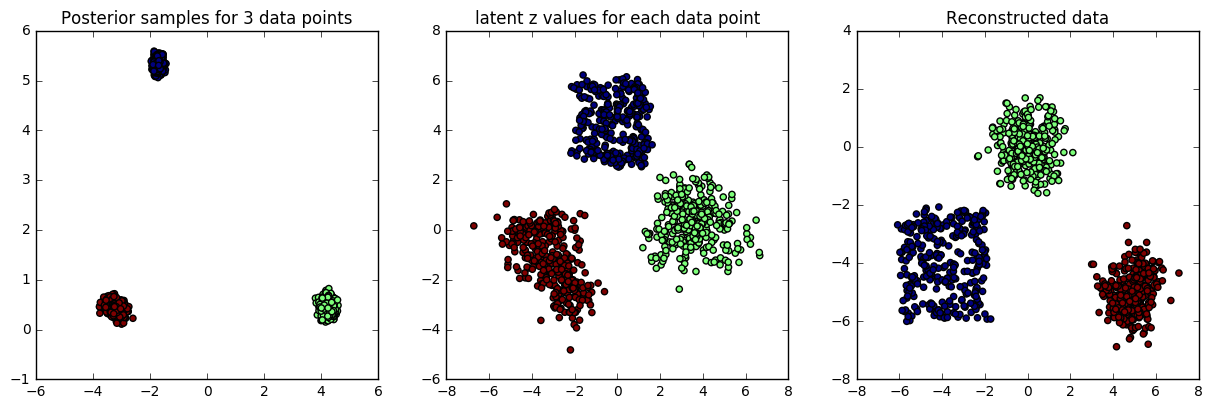

In [25]:
plot_results(ops, xs, ys)

### Trained Model Visualizations for Writeup

In [1]:
%pylab inline

import os
from glob import glob

/Users/wellecks/own_files/env/minpy_dev/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


Populating the interactive namespace from numpy and matplotlib


In [12]:
import os
from glob import glob
import numpy as np

ROOT_DIR = 'results/shanghai/results'

dirs = [d for d in os.listdir(ROOT_DIR)
        if os.path.isdir(os.path.join(ROOT_DIR, d))]

full_dirs = [os.path.join(ROOT_DIR, d) for d in os.listdir(ROOT_DIR)
             if os.path.isdir(os.path.join(ROOT_DIR, d))]

methods = ['-'.join(d.split('-')[5:]) for d in dirs]

data_types = ['log_p_x_given_zk_train',
              'log_p_x_given_zk_valid',
              'log_p_zk_train',
              'log_p_zk_valid',
              'log_q0_z0_train',
              'log_q0_z0_valid',
              'log_qk_zk_train',
              'log_qk_zk_valid',
              'raw_kl_train',
              'raw_kl_valid',
#               'real_visualizations',
              'rec_err_train',
              'rec_err_valid',
#               'sample_visualizations',
              'sum_log_detj_train',
              'sum_log_detj_valid',
              'train_loss_train',
              'train_loss_valid',
              'training_losses',
              'unweighted_elbo_train',
              'unweighted_elbo_valid',
              'valid_loss_train',
              'valid_loss_valid',
              'validation_losses',
              'weighted_elbo_train',
              'weighted_elbo_valid',
              'weighted_kl_train',
              'weighted_kl_valid']


# load last (largest epoch #) for each data type for each method
data = {}
for data_type in data_types:
    data[data_type] = {}
    for d, method in zip(full_dirs, methods):
        npy_filepaths = glob(os.path.join(d, '%s*' % data_type))

        # no number if the training fully completed
        last = None
        best = -1
        for fp in npy_filepaths:
            if fp.endswith('%s.npy' % data_type):
                last = fp
                break
            else:
                
                n = int(fp.split('_')[-1][:-4])
                if n > best:
                    last = fp
                    best = n

        data[data_type][method] = np.load(fp)


In [84]:
import seaborn as sns
from matplotlib import rc

sns.set(rc={'image.cmap': 'jet'})
sns.set_style(style='white')
rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
rc('text', usetex=True)

#### Training loss

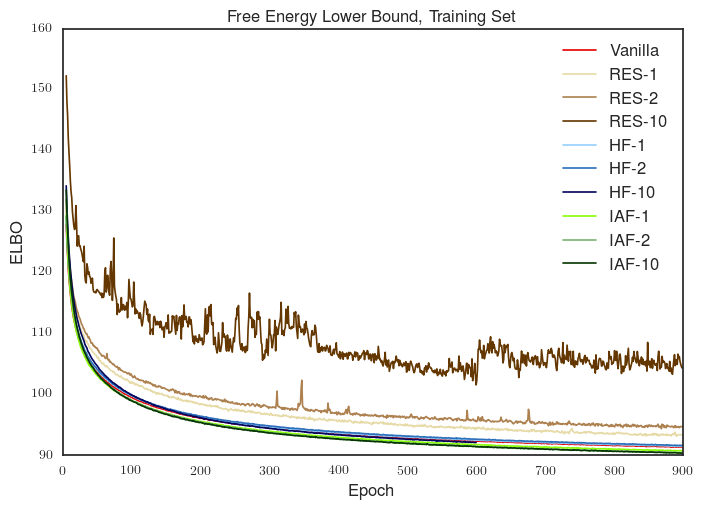

In [225]:
ms = ['basic', 'NF-1', 'NF-2', 'NF-10', 'HF-1', 'HF-2', 'HF-10', 'IAF-1', 'IAF-2', 'IAF-10']
ls = ['Vanilla', 'RES-1', 'RES-2', 'RES-10', 'HF-1', 'HF-2', 'HF-10', 'IAF-1', 'IAF-2', 'IAF-10']
colors = ['red', 'beige', 'light brown', 'brown', 'light blue', 'medium blue', 'dark blue', 'lime green', 'faded green', 'dark green']
cs = sns.xkcd_palette(colors)

data_type = 'train_loss_train'
d = data[data_type]
k = 900

for i, m in enumerate(ms):
    plt.plot(np.arange(len(d[m]))[5:k], d[m][5:k], linewidth='1.2', c=cs[i])

plt.xlabel('Epoch', fontsize=12)
plt.ylabel('ELBO', fontsize=12)
plt.title('Free Energy Lower Bound, Training Set', fontsize=12)
plt.legend(ls, fontsize=12)
plt.savefig('elbo.eps', format='eps', dpi=1000)

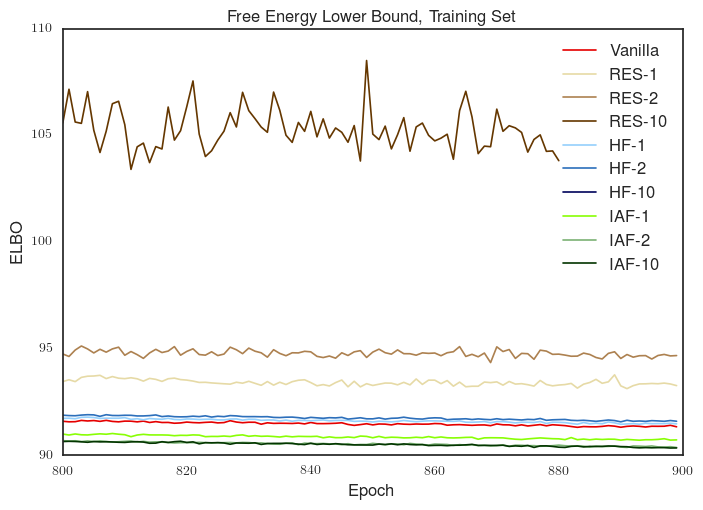

In [224]:
ms = ['basic', 'NF-1', 'NF-2', 'NF-10', 'HF-1', 'HF-2', 'HF-10', 'IAF-1', 'IAF-2', 'IAF-10']
ls = ['Vanilla', 'RES-1', 'RES-2', 'RES-10', 'HF-1', 'HF-2', 'HF-10', 'IAF-1', 'IAF-2', 'IAF-10']
colors = ['red', 'beige', 'light brown', 'brown', 'light blue', 'medium blue', 'dark blue', 'lime green', 'faded green', 'dark green']
cs = sns.xkcd_palette(colors)

data_type = 'train_loss_train'
d = data[data_type]

for i, m in enumerate(ms):
    if m == 'NF-10':
        end = 881
    else:
        end = 900
    plt.plot(np.arange(len(d[m]))[800:end], d[m][800:end], linewidth='1.2', c=cs[i])

plt.xlabel('Epoch', fontsize=12)
plt.ylabel('ELBO', fontsize=12)
plt.title('Free Energy Lower Bound, Training Set', fontsize=12)
plt.legend(ls, fontsize=12)
plt.savefig('elbo_zoomed.eps', format='eps', dpi=1000)
# plt.show()

#### `KL[q(z|x) || p(z)]` for residual flow methods



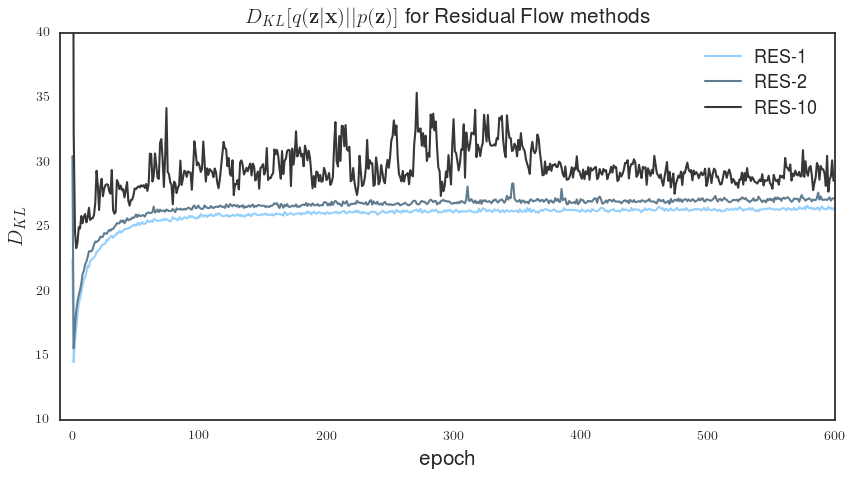

In [200]:
ms = ['NF-1', 'NF-2', 'NF-10']
ls = ['RES-1', 'RES-2', 'RES-10']
colors = ['light blue', 'blue grey', 'dark grey']

cs = sns.xkcd_palette(colors)

data_type = 'raw_kl_train'
d = data[data_type]

plt.figure(figsize=(10, 5))
for i, m in enumerate(ms):
    plt.plot(np.arange(len(d[m]))[:600], d[m][:600], linewidth='1.5', c=cs[i])
    
plt.title('$D_{KL}[q(\mathbf{z}|\mathbf{x}) ||  p(\mathbf{z})]$ for Residual Flow methods', fontsize=15)
plt.ylim([10, 40])
plt.xlim([-10, 600])
plt.xlabel('epoch', fontsize=15)
plt.ylabel('$D_{KL}$', fontsize=15)
plt.legend(ls, fontsize=13)
plt.savefig('dkl.eps', format='eps', dpi=1000)
# plt.show()

#### IAF 'contractions'

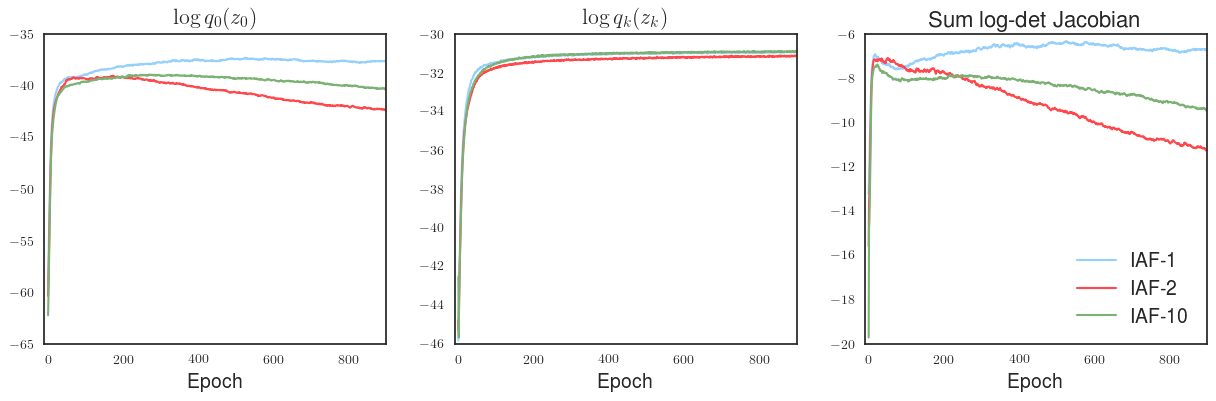

In [219]:
ms = ['IAF-1', 'IAF-2', 'IAF-10']

colors = ['light blue', 'light red', 'faded green']

cs = sns.xkcd_palette(colors)
k = 900


fig, axs = plt.subplots(1, 3, figsize=(15, 4))

data_type = 'log_q0_z0_train'
d = data[data_type]
for i, m in enumerate(ms):
    axs[0].plot(np.arange(len(d[m]))[:k], d[m][:k], linewidth='1.5', c=cs[i])
    
data_type = 'log_qk_zk_train'
d = data[data_type]
for i, m in enumerate(ms):
    axs[1].plot(np.arange(len(d[m]))[:k], d[m][:k], linewidth='1.5', c=cs[i])
    
data_type = 'sum_log_detj_train'
d = data[data_type]
for i, m in enumerate(ms):
    axs[2].plot(np.arange(len(d[m]))[:k], d[m][:k], linewidth='1.5', c=cs[i])
    
axs[0].set_title('$\log q_0(z_0)$', fontsize=16)
axs[1].set_title('$\log q_k(z_k)$', fontsize=16)
axs[2].set_title('Sum log-det Jacobian', fontsize=16)

for i in range(3):
    axs[i].set_xlim([-10, k])
    axs[i].set_xlabel('Epoch', fontsize=14)

# plt.title('$D_{KL}[q(\mathbf{z}|\mathbf{x}) ||  p(\mathbf{z})]$ for Residual Flow methods')
# plt.ylim([10, 40])
# plt.xlabel('epoch')
# plt.ylabel('$D_{KL}$')
plt.legend(ms, loc='lower right', fontsize=14)
plt.savefig('contractions.eps', format='eps', dpi=1000)
# plt.show()

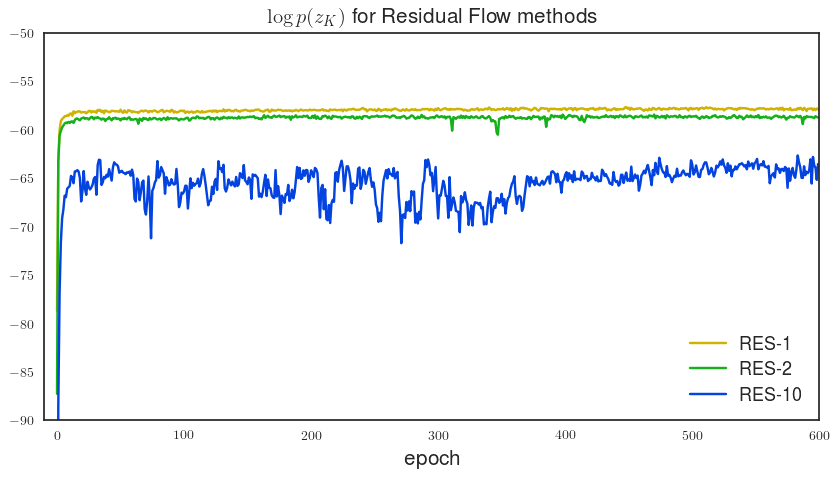

In [218]:
ms = ['NF-1', 'NF-2', 'NF-10']
ls = ['RES-1', 'RES-2', 'RES-10']
colors = ['mustard', 'green', 'blue']

cs = sns.xkcd_palette(colors)
k = 900

data_type = 'log_p_zk_train'
d = data[data_type]

plt.figure(figsize=(10, 5))
for i, m in enumerate(ms):
    plt.plot(np.arange(len(d[m]))[:600], d[m][:600], linewidth='1.75', c=cs[i])
    
plt.title('$\log p(z_K)$ for Residual Flow methods', fontsize=15)
plt.xlim([-10, 600])
plt.ylim([-90, -50])
plt.xlabel('Epoch', fontsize=15)
plt.legend(ls, fontsize=13, loc='lower right')
plt.savefig('pzk.eps', format='eps', dpi=1000)
# plt.show()